In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM, load_random_exp_povm
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import clustering as cl
from EMQST_lib.qrem import QREM
from joblib import Parallel, delayed
import time
import uuid
import scipy.cluster.hierarchy as sch
from EMQST_lib import support_functions as sf
plt.rcParams.update({'font.size': 15})
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

# QREM on 16 qubits with structure, using (realistic exp. data)

In [9]:
# Generate new dictionary for current run
base_path = 'QDOT_results/16_exp_example'
data_path = sf.generate_data_folder(base_path)

sim_dict ={
    'n_qubits': 16,
    'n_QST_shots': 10**3,
    'n_QDT_shots': 10**4,
    'n_hash_symbols': 4,
    'n_cores': 9,
    'max_cluster_size': 3,
    'data_path': data_path,
}


# Ensure that cluster_sizes is a numpy array of integers
cluster_size = np.array([1, 3, 1, 3, 2, 2, 1, 2, 1], dtype=int)

qrem = QREM(sim_dict)

qrem.print_current_state()

qrem.set_initial_cluster_size(cluster_size)
povm_mode = 'weak'
qrem.set_exp_POVM_array( noise_mode = povm_mode)
qrem.perform_QDT_measurements()
qrem.save_initialization()


Using hash from perfect_hash(9,16,4).npy.
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 2,272 x 10,000.
QST shots for arbitrary 4-RDM reconstruction: 705 x 1,000.
Loaded 9 POVMs from Exp_povms/Extracted_modified.
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done 126 tasks      | elapsed:    0.2s
[Parallel(n_jobs=9)]: Done 1422 tasks      | elapsed:    3.3s
[Parallel(n_jobs=9)]: Done 2223 tasks      | elapsed:    5.2s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:    5.3s finished


Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   17.3s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   30.6s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    7.2s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   12.1s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   16.2s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   20.7s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   27.2s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   33.1s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   41.2s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:   48.0s
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:   56.2s
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.1min remaining:    2.3s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.1min finished


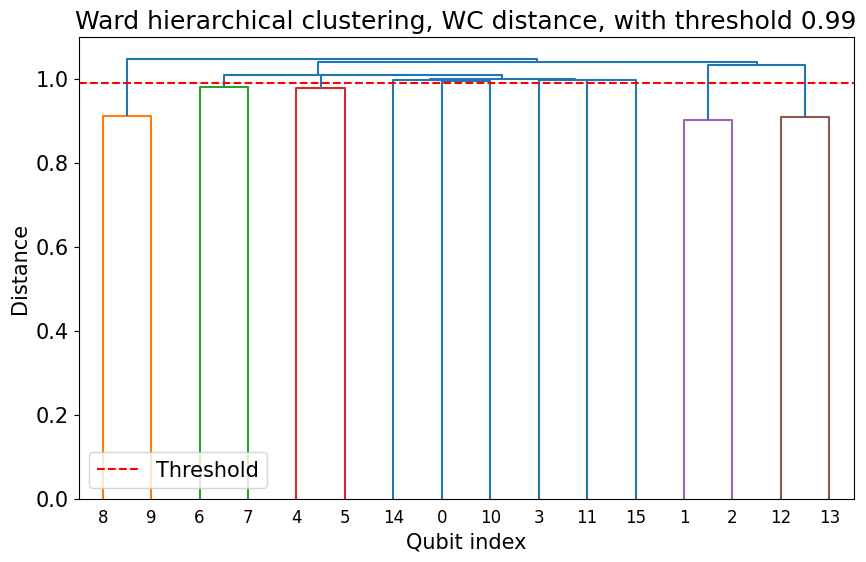

In [10]:
qrem.perform_clustering(max_cluster_size=3)
vis.plot_dendrogram(qrem)

In [27]:
qrem.reconstruct_all_one_qubit_POVMs()
qrem.reconstruct_cluster_POVMs()
qrem.reconstruct_cluster_with_perfect_clustering()
n_averages = 3
chunk_size = 4
qrem.set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size)
qrem.perform_averaged_QST_measurements()

selected_two_point_corr_labels = np.array([[0,1], [2,3]])
qrem.set_two_point_correlators( two_point_corr_labels = selected_two_point_corr_labels)
recon_mode = [0,1,2,3,4,5]

standard_dict = qrem.perform_two_point_correlator_QST(recon_mode)
perfect_clustering_dict = qrem.perform_two_point_correlator_QST(recon_mode, assume_perfect_clustering=True)

dict_array = [standard_dict, perfect_clustering_dict]

with open(f'{qrem.data_path}/result_QST.npy', 'wb') as f:
    np.save(f, dict_array)

perm_data_path = f'{qrem.data_path}'



[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    3.2s remaining:   14.4s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    5.2s remaining:   11.5s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:    5.5s remaining:    7.1s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:    5.7s remaining:    4.4s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:    6.1s remaining:    2.7s
[Parallel(n_jobs=9)]: Done  13 out of  16 | elapsed:    6.5s remaining:    1.4s
[Parallel(n_jobs=9)]: Done  16 out of  16 | elapsed:    7.6s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of  11 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=9)]: Done   4 out of  11 | elapsed:    2.7s remaining:    4.9s
[Parallel(n_jobs=9)]: Done   6 out of  11 | elapsed:    3.3s remaining:    2.8s
[Parallel(n_jobs=9)]: Done   8 out of  11 | elapsed:    3.8s

Set current two-point correlators to [[0 1]
 [2 3]].


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    3.3s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.6s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.7s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.7s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.7s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.6s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   2 | elapsed:    0.5s finished


POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)


6
3
2
4
4
(6, 2)


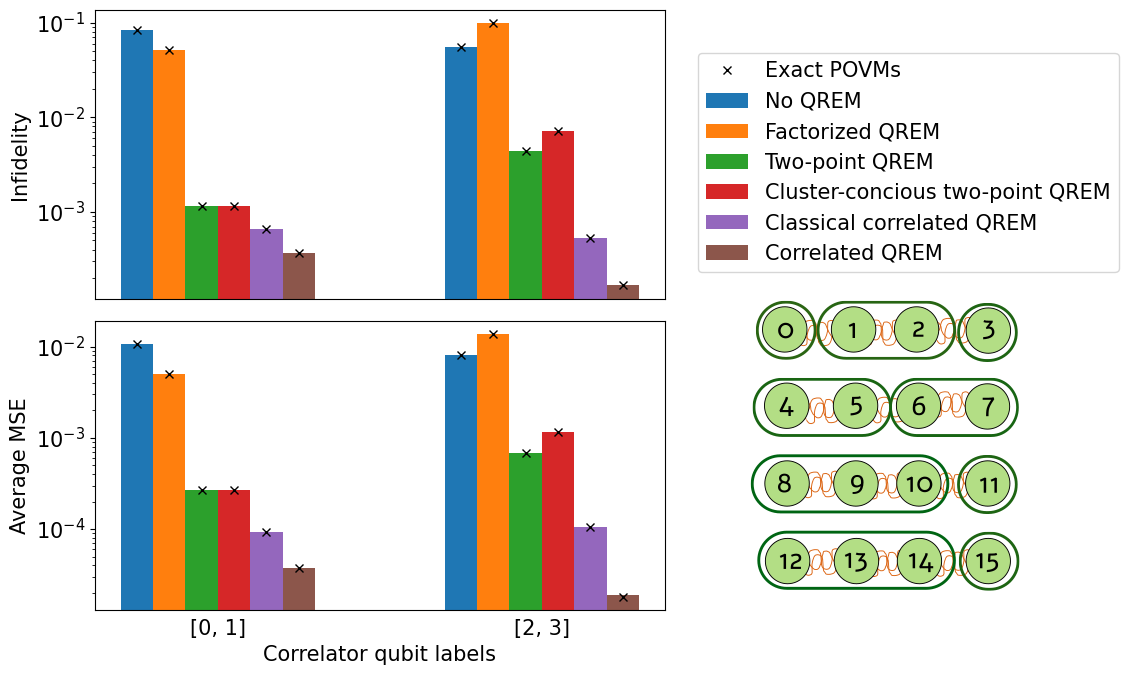

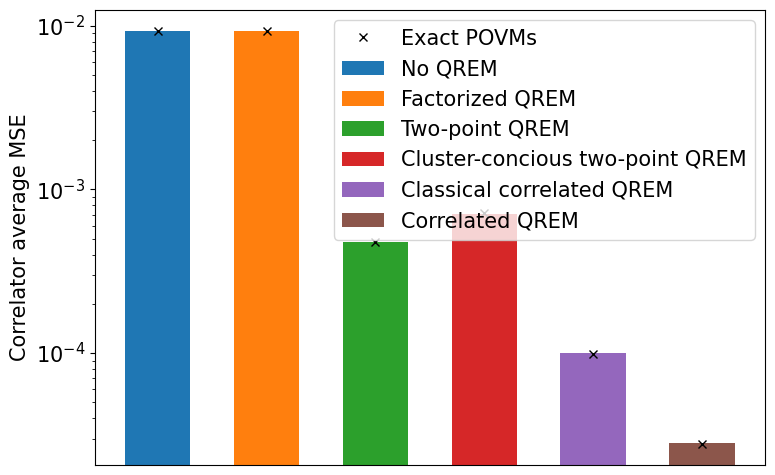

In [ ]:
# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"

with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
    dict_array = np.load(f, allow_pickle=True)

standard_dict = dict_array[0]
perfect_clustering_dict = dict_array[1]
n_averages = standard_dict['n_average']
two_point_corr_labels   = standard_dict['two_point_corr_labels']
traced_down_rho_true_array = standard_dict['traced_down_rho_true_array']

standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict)
perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)
# The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]

fig, ax = plt.subplots(2,1)
x = np.arange(len(two_point_corr_labels))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

standard_inf_array = ot.compute_mode_mean_infidelitites(standard_state_array, traced_down_rho_true_array)
perfect_inf_array = ot.compute_mode_mean_infidelitites(standard_state_array, traced_down_rho_true_array)
print(standard_inf_array.shape)
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[0].bar(x + offset,standard_inf_array[i], width, label=label_array[i])
    ax[0].plot(x + offset, perfect_inf_array[i], "kx", label="Exact POVMs" if multiplier == 0 else "")
    multiplier += 1
ax[0].set_yscale('log')
ax[0].set_xticks(x + 2.5*width, two_point_corr_labels)
ax[0].set_ylabel('Infidelity')


# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)




true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]
stadard_exp_value = ot.compute_state_array_exp_values(standard_state_array,op_string_array)

standard_mean_MSE = ot.compute_op_and_n_averages_mean_MSE(stadard_exp_value, true_exp_value)
perfect_clustering_exp_value = ot.compute_state_array_exp_values(perfect_state_array,op_string_array)
perfect_clustering_MSE = ot.compute_op_and_n_averages_mean_MSE(perfect_clustering_exp_value, true_exp_value)

# MSE of shape [n_method , n_correlators]
corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]
x = np.arange(len(corr_x_label))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, standard_mean_MSE[i], width)
    ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx")
    multiplier += 1
    
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')
ax[-1].set_xticks(x + 2.5*width, corr_x_label)
ax[-1].set_xlabel('Correlator qubit labels')
img = plt.imread("images/cluster_formation_16.png")
fig.figimage(img, 750, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1,0.75))
handels, labels = ax[0].get_legend_handles_labels()





fig_main, ax_main = plt.subplots(1,1)
standard_mean_MSE = np.mean(standard_mean_MSE, axis=1)
perfect_mean_MSE = np.mean(perfect_clustering_MSE, axis=1)
bars = ax_main.bar(label_array, standard_mean_MSE, width*6, color=['C0', 'C1','C2','C3','C4', 'C5'])
ax_main.plot(label_array, perfect_mean_MSE, "kx")
#ax_main.set_title('Average MSE over random correlators')
ax_main.set_ylabel('Correlator average MSE')
ax_main.set_yscale('log')
ax_main.legend(handels, labels)
ax_main.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig_main.set_size_inches(8, 5)
fig_main.tight_layout()
#fig_main.legend(loc='center left', bbox_to_anchor=(1,0.75))



# QREM on 16 qubit for many differnet depolarizing ISAWP noise

In [ ]:
# Define parameters
n_QST_shots = 10**3
n_QDT_shots = 10**4
n_hash_symbols = 4
n_qubits = 16
use_chunks = True # If true, the nois POVMs and sampled will be split into chunks of chunk_size, 
                 # and sampled as genuine chunk-qubit states. Nessecary for entangled states. 
chunk_size = 4 # For entangled sampling states
n_chunks = int(n_qubits/chunk_size)
path = f"EMQST_lib/hash_family/"
save_raw_data = False # If false, only processes data will be saved. If true, raw sample data will be saved as well. 
n_cores = 9

# 1.1. Load/create the hashing use for protocol
if n_hash_symbols>2:
    hash_family = None
    for files in os.listdir(path):
        if files.endswith(f"{n_qubits},{n_hash_symbols}).npy"):
            print(files)
            with open(f'{path}{files}' ,'rb') as f:
                hash_family = np.load(f)
            break # This break is to make sure it does not load a worse hash if it is stored.
    if hash_family is None: 
        raise ValueError("Did not find hash for this combination, please change settings or create relevant perfect hash family.")
else: # For k=2 we can use the 2-RDM hash family
    hash_family = ot.create_2RDM_hash(n_qubits)
n_hashes = len(hash_family)

print("The shot budget of the currents settings are:")
print(f'QDT shots for computational basis reconstruction: {(n_hashes*(4**n_hash_symbols -4) +4):,} x {n_QDT_shots:,}.')
print(f'QST shots for arbitrary {n_hash_symbols}-RDM reconstruction: {(n_hashes*(3**n_hash_symbols -3) +3):,} x {n_QST_shots:,}.')


# Generate noisey povm
print(f'Random strenght ISWAP noise.')
cluster_cap = 3
cluster_size = np.ones(int(n_qubits/2),dtype=int)*2
n_clusters = len(cluster_size)
local_noise_mode = 1
print(f'The total number of qubits are {sum(cluster_size)}, with {n_clusters} clusters.' )
comp_povm_array = POVM.generate_computational_POVM(2)[0].get_POVM()

ISWAP=np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]],dtype=complex)

# The noise strenght will be drawn at random around 0.5 the k-mean

noise_transformation = ISWAP
k_mean_array = np.array([0.2,0.4,0.6,0.8])
random_strenght_array =  np.array([(np.random.random(int(n_qubits/2))*0.2 - 0.1) + k_mean for k_mean in k_mean_array]) # Mixing strenght (probability)
print(random_strenght_array)

povm_matrix = [[POVM((1-k)*comp_povm_array + k*np.einsum('jk,ikl,lm->ijm',noise_transformation.conj().T,comp_povm_array,noise_transformation)) for k in k_realization_array ] for k_realization_array in random_strenght_array]

# Define an IC calibration basis, here we use the SIC states (by defining the angles (as will be used for state preparation))
one_qubit_calibration_angles = np.array([[[0,0]],[[2*np.arccos(1/np.sqrt(3)),0]],
                                                 [[2*np.arccos(1/np.sqrt(3)),2*np.pi/3]],
                                                 [[2*np.arccos(1/np.sqrt(3)),4*np.pi/3]]])
one_qubit_calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in one_qubit_calibration_angles])


# These are the instructions that that need to be applied to each qubit.
possible_QDT_instructions = np.array([0, 1, 2, 3]) # For QDT we need to measure each of the 4 calibration states.  
# Experiment equivalent =  one_qubit_calibration_angles
possible_QST_instructions = np.array(["X", "Y", "Z"]) # For QST we need to meaure each qubit in the 3 Pauli basis.
# Experiment equivalent = [[pi/2, 0], [pi/2, pi/2], [0,0]]


perfect_hash(9,16,4).npy
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 2,272 x 10,000.
QST shots for arbitrary 4-RDM reconstruction: 705 x 1,000.
Random strenght ISWAP noise.
The total number of qubits are 16, with 8 clusters.
[[0.265 0.105 0.241 0.189 0.235 0.109 0.185 0.212]
 [0.406 0.423 0.455 0.456 0.361 0.33  0.33  0.314]
 [0.648 0.663 0.515 0.625 0.58  0.653 0.53  0.642]
 [0.733 0.861 0.799 0.709 0.818 0.716 0.753 0.762]]


In [4]:
QDOT_run_dictionary = {
    "n_QST_shots": n_QST_shots,
    "n_QDT_shots": n_QDT_shots,
    "n_hash_symbols": n_hash_symbols,
    "n_qubits": n_qubits,
    "n_cores": n_cores,
    "hash_family": hash_family,
    "n_hashes": n_hashes,
    "povm_array": [[povm.get_POVM() for povm in realization]for realization in povm_matrix], # Can be of inhomogenious shape.
    "noise_cluster_size": cluster_size,
    "n_clusters": n_clusters,
    "possible_QDT_instructions": possible_QDT_instructions,
    "possible_QST_instructions": possible_QST_instructions,
    "random_strenght_array": random_strenght_array
    }

# Create QDT instructions based on hashing (covering arrays) 
hashed_QDT_instructions = ot.create_hashed_instructions(hash_family, possible_QDT_instructions, n_hash_symbols)
# Create hashed calibration states
hashed_calib_states = np.array([ot.calibration_states_from_instruction(instruction, one_qubit_calibration_states) for instruction in hashed_QDT_instructions])
print('Hashed calibration states shape:', hashed_calib_states.shape)

# Simulate all instruction measurements
print(f'Simulating QDT measurements for {n_qubits} qubits.')
QDT_outcomes_parallel = [Parallel(n_jobs = n_cores, verbose = 5)(delayed(mf.measure_clusters)(n_QDT_shots, povm_array, rho_array, cluster_size) for rho_array in hashed_calib_states) for povm_array in povm_matrix]
QDT_outcomes_array = np.asarray(QDT_outcomes_parallel)

print('QDT outcomes shape:', QDT_outcomes_array.shape)

# Make saving folder for this run
# Check if restuls exist:
check_path='QDOT_results'
path_exists=os.path.exists(check_path)
if not path_exists:
    print("Created QDOT_results dictionary.")
    os.makedirs('QDOT_results')

# Generate new dictionary for current run
now=datetime.now()
now_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
dir_name= now_string+str(uuid.uuid4())


data_path=f'QDOT_results/{dir_name}'
os.mkdir(data_path)


# Save run settings
with open(f'{data_path}/run_settings.npy','wb') as f:
    np.save(f,QDOT_run_dictionary)


Hashed calibration states shape: (2272, 16, 2, 2)
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:    8.4s
[Parallel(n_jobs=9)]: Done 342 tasks      | elapsed:    9.2s
[Parallel(n_jobs=9)]: Done 1350 tasks      | elapsed:   11.7s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:   14.1s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done 126 tasks      | elapsed:    0.3s
[Parallel(n_jobs=9)]: Done 846 tasks      | elapsed:    2.2s
[Parallel(n_jobs=9)]: Done 1854 tasks      | elapsed:    5.3s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:    6.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done 126 tasks      | elapsed:    0.3s
[Parallel(n_jobs=9)]: Done 846 tasks      | elapsed:    2.2s
[Parallel(n_jobs=9)]: Done 1854 tasks      | elapsed:    4.7s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:    5.7s finished
[Parall

QDT outcomes shape: (4, 2272, 10000, 16)


Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   29.2s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   54.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    3.3s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:    8.6s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   11.8s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   15.5s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   18.5s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:   26.4s
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:   31.3s
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:   41.9s remaining:    1.3s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   43.0s finished


Fluctuation limit: 0.01
Found cluster lables:
 WC: [[8, 9], [0, 1], [12, 13], [2, 3], [4, 5], [6, 7], [14, 15], [10, 11]]
Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   24.8s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   48.3s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:    7.5s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:    9.4s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   12.3s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   16.6s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   20.1s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   24.0s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:   27.9s
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:   33.3s
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:   41.7s remaining:    1.3s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   44.1s finished


Fluctuation limit: 0.01
Found cluster lables:
 WC: [[8, 9], [12, 13], [0, 1], [10, 11], [14, 15], [2, 3], [6, 7], [4, 5]]
Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   27.4s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   53.6s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    9.2s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   12.0s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   17.5s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   21.5s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   28.1s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   32.4s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   41.3s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:   48.4s
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:   56.6s
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.1min remaining:    2.2s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.2min finished


Fluctuation limit: 0.01
Found cluster lables:
 WC: [[10, 11], [2, 3, 14, 15], [12, 13], [4, 5], [6, 7], [0, 1], [8, 9]]
Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   23.0s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   49.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    9.3s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   18.0s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   27.1s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   36.4s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   44.7s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   54.1s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.3min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.5min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.9min remaining:    3.7s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.9min finished


Fluctuation limit: 0.01
Found cluster lables:
 WC: [[10, 11], [2, 3, 14, 15], [4, 5, 12, 13], [6, 7], [0, 1, 8, 9]]


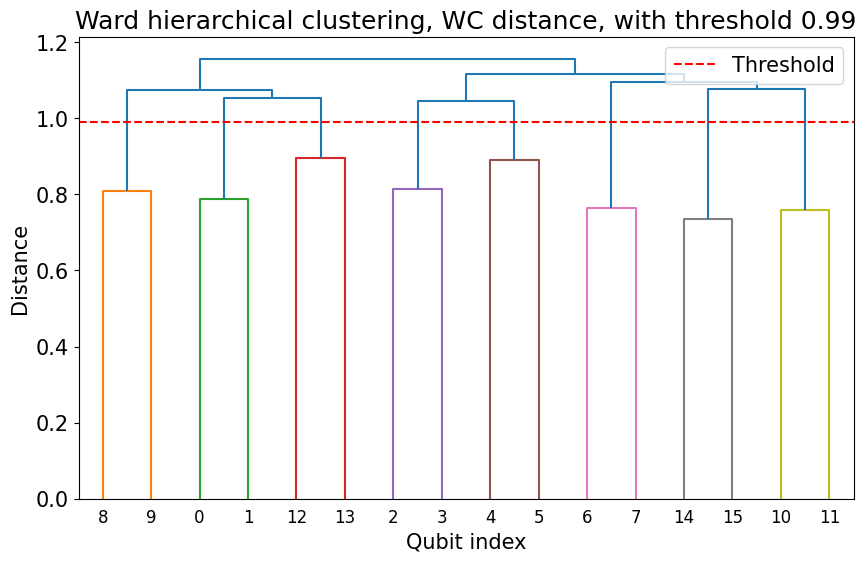

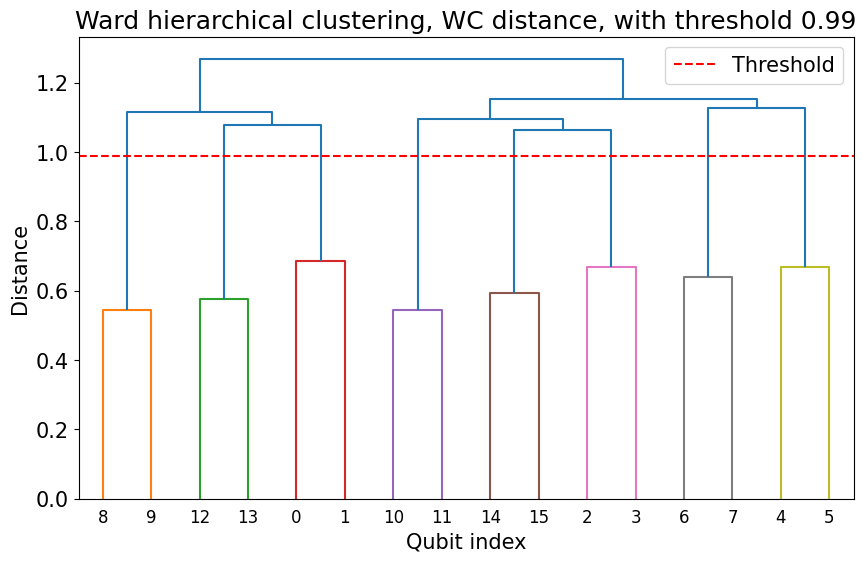

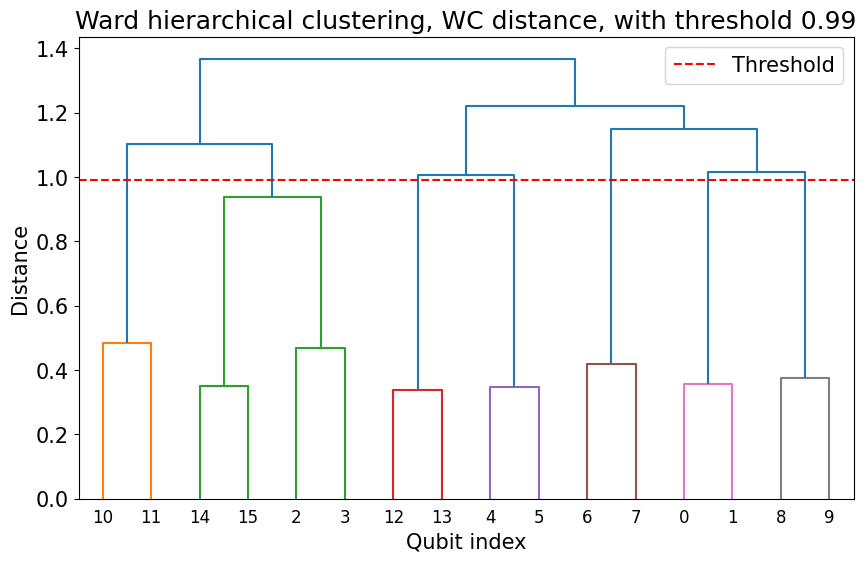

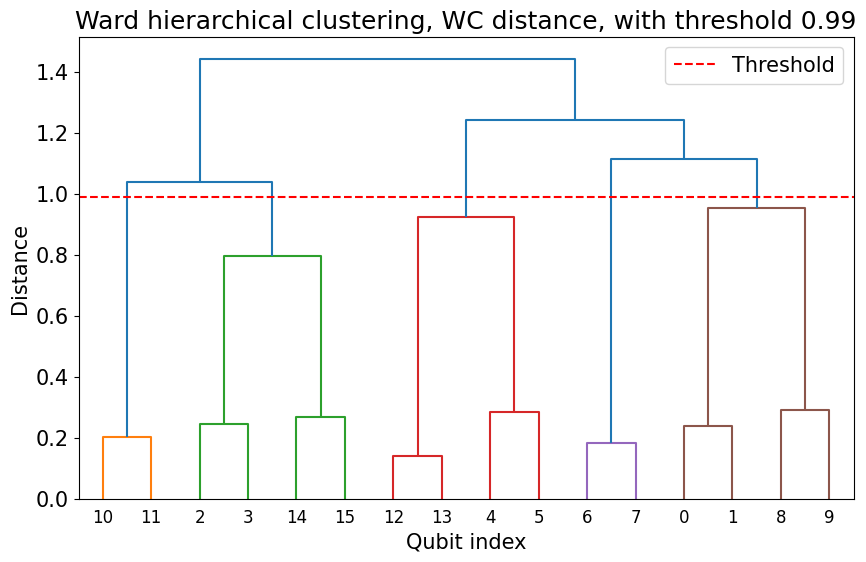

In [ ]:
noise_cluster_labels_array = []
for QDT_outcomes in QDT_outcomes_array:
    # Generate correlation coefficients
    print(f'Create all possible 2 qubit POVMs for correlation map.')
    two_point_POVM, corr_subsystem_labels = ot.reconstruct_all_two_qubit_POVMs(QDT_outcomes, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

    summed_quantum_corr_array, unique_corr_labels = ot.compute_quantum_correlation_coefficients(two_point_POVM, corr_subsystem_labels)
    dist_matrix_WC = cl.create_distance_matrix_from_corr(summed_quantum_corr_array, unique_corr_labels, n_qubits)

    # Find clustering
    fluctuation_limit = 1/np.sqrt(n_QDT_shots)
    thr = 1 - fluctuation_limit
    print(f'Fluctuation limit: {fluctuation_limit}')	
    fcluster_labels_WC, Z_WC = cl.ward_clustering(dist_matrix_WC, thr)

    noise_cluster_labels_temp = cl.fcluster_to_labels(fcluster_labels_WC)

    print(f'Found cluster lables:\n WC: {cl.fcluster_to_labels(fcluster_labels_WC)}')
    # Create the dendrogram

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    dn1 = sch.dendrogram(Z_WC, ax=ax, above_threshold_color='C0',
                            orientation='top', color_threshold=thr)


    ax.plot([0, 1000], [thr, thr], 'r--',  label = 'Threshold' )
    ax.set_ylabel('Distance')
    ax.set_xlabel('Qubit index')
        #axes[i].set_ylim([0., 1.4])
    ax.set_title(f'Ward hierarchical clustering, WC distance, with threshold {thr}')

    ax.legend()
    sch.set_link_color_palette(None)  # reset to default after use

    # If clustering is too large:
    cluster_sizes = [len(item) for item in cl.fcluster_to_labels(fcluster_labels_WC)]
    max_cluster_size = 4
    if max(cluster_sizes) > max_cluster_size:
        print("Initial Cluster Assignments:", cl.fcluster_to_labels(fcluster_labels_WC))
        # Split large clusters
        max_size = 4
        final_assignments = cl.split_large_clusters(dist_matrix_WC, fcluster_labels_WC, max_size)
        noise_cluster_labels_temp = cl.fcluster_to_labels(final_assignments)
        
        print("Final Cluster Assignments:", noise_cluster_labels_temp)
    
    noise_cluster_labels_array.append(noise_cluster_labels_temp)


In [16]:
# Reconstruct the POVMs decided by the clustering

true_cluster_labels = cl.get_true_cluster_labels(cluster_size)
one_qubit_POVMs_array = [ot.reconstruct_all_one_qubit_POVMs(QDT_outcomes, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores) for QDT_outcomes in QDT_outcomes_array]


perfect_clustered_QDOT_array = [ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, cl.get_true_cluster_labels(cluster_size), n_qubits,
                                                                hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores) for QDT_outcomes in QDT_outcomes_array]


clustered_QDOT_array = [ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, noise_cluster_labels, n_qubits, hash_family, n_hash_symbols,
                                                        one_qubit_calibration_states, n_cores) for QDT_outcomes, noise_cluster_labels in zip(QDT_outcomes_array,noise_cluster_labels_array)]
    
print(f"Noise labels: {noise_cluster_labels_array}")
print(f"True labels: {true_cluster_labels}")

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Batch computation too fast (0.19495201110839844s.) Setting batch_size=2.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    0.9s remaining:    2.1s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:    1.2s remaining:    1.6s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:    2.8s remaining:    2.2s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=9)]: Done  13 out of  16 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=9)]: Done  16 out of  16 | elapsed:    4.1s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    5.3s remaining:   23.3s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    5.4s remaining:   11.9s
[Parallel(n_jobs=9)]: Done   7 out of  16 | e

Noise labels: [[[8, 9], [0, 1], [12, 13], [2, 3], [4, 5], [6, 7], [14, 15], [10, 11]], [[8, 9], [12, 13], [0, 1], [10, 11], [14, 15], [2, 3], [6, 7], [4, 5]], [[10, 11], [2, 3, 14, 15], [12, 13], [4, 5], [6, 7], [0, 1], [8, 9]], [[10, 11], [2, 3, 14, 15], [4, 5, 12, 13], [6, 7], [0, 1, 8, 9]]]
True labels: [array([15, 14]), array([13, 12]), array([11, 10]), array([9, 8]), array([7, 6]), array([5, 4]), array([3, 2]), array([1, 0])]


[Parallel(n_jobs=9)]: Done   5 out of   5 | elapsed:  1.0min finished


In [126]:
# Select random two point correlators to extract, will be the same over all noise realizations
two_point_corr_labels = np.array([[0,1],[2,3],[8,1],[10,6] ]) #ot.generate_random_pairs_of_qubits(n_qubits, 2)

# Reconstruct spesiffic two_point_povms
two_point_POVM_array = [ot.reconstruct_spesific_two_qubit_POVMs(QDT_outcomes, two_point_corr_labels , n_qubits, hash_family, 
                                                         n_hash_symbols, one_qubit_calibration_states, n_cores) for QDT_outcomes in QDT_outcomes_array]
hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)


n_QST_shots_total = n_QST_shots
# Define the two point correlators to extract: 

# Perform comparative QST over many averaged random states. 
n_averages = 1
start = time.time()
QST_outcome_matrix = []
true_rho_average_matrix = []
traced_down_correlator_rho_true_matrix = []

k_it = 0
for iterator in range(len(QDT_outcomes_array)):
    QST_outcomes_array = []

    true_rho_average_array = []
    traced_down_correlator_rho_true_array = []
    for k in range(n_averages):
        #if use_chunks:
        state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
        rho_true_array = [sf.generate_random_pure_state(size) for size in state_size_array]
        rho_true_labels = cl.get_true_cluster_labels(state_size_array)
        QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots, chunk_size, povm_matrix[iterator], cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)
        rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels_array[iterator], two_point_corr_labels)
        for i in range(len(two_point_corr_labels)):
            traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], two_point_corr_labels[i])) for i in range(len(rho_true_list))]
        traced_down_correlator_rho_true_array.append(traced_down_rho_true)
        true_rho_average_array.append(rho_true_array)
        QST_outcomes_array.append(QST_outcomes)
        
    # QST_outcome_matrix.append(QST_outcomes_array)
    # true_rho_average_matrix.append(true_rho_average_array)
    # traced_down_correlator_rho_true_matrix.append(traced_down_correlator_rho_true_array)
    
    print(f'Sampling runtime for run {k}: {time.time()-start}')

    # Select the relevant methods 
    # 0: no QREM
    # 1: factorized QREM
    # 2: two RDM QREM
    # 3: Cluster-concious two-point QREM
    # 4: Classical correlated QREM
    # 5: Entanglement safe QREM
    methods = [0,2,5]

    standard_result_QST_dict = ot.perform_full_comparative_QST(noise_cluster_labels_array[iterator], QST_outcomes_array, two_point_corr_labels, 
                                                    clustered_QDOT_array[iterator], one_qubit_POVMs_array[iterator], two_point_POVM_array[iterator], n_averages, data_path, 
                                                    hash_family, n_hash_symbols, n_qubits, n_cores, method = methods)
        
    
    correct_clustering_result_QST_dict = ot.perform_full_comparative_QST(true_cluster_labels, QST_outcomes_array, two_point_corr_labels, 
                                                    perfect_clustered_QDOT_array[iterator], one_qubit_POVMs_array[iterator], two_point_POVM_array[iterator], n_averages, data_path, 
                                                    hash_family, n_hash_symbols, n_qubits, n_cores, method = methods)

        
    dict_array = [standard_result_QST_dict,correct_clustering_result_QST_dict]

    for dict in dict_array:
        dict["true_rho_average_array"] = true_rho_average_array
        dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array 
        dict["cluster_size"] = cluster_size
        dict["n_QDT_shots"] = n_QDT_shots  
        dict["n_QST_shots"] = n_QST_shots
        dict["k-mean_array"] = k_mean_array
        dict["random_strenght_array"] = random_strenght_array
        
    with open(f'{data_path}/k={k_mean_array[k_it]}result_QST.npy', 'wb') as f:
        np.save(f, standard_result_QST_dict)
        np.save(f, correct_clustering_result_QST_dict)
    k_it += 1

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.8s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    3.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elap

Sampling runtime for run 0: 0.5830862522125244
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
Sampling runtime for run 0: 51.47294902801514
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
Sampling runtime for run 0: 103.85768842697144
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
Sampling runtime for run 0: 171.27719831466675
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


## Plotting for the iSWAp noise case

[[[[0.010087763781022496, 0.001365440647820293]], [[3.349505850069878e-05, 3.096042579331382e-05]], [[3.349505850069878e-05, 3.096042579331382e-05]]], [[[0.030184439505054228, 0.011025940216348173]], [[7.510456297832313e-05, 7.044365938435604e-05]], [[7.510456297832313e-05, 7.044365938435604e-05]]], [[[0.0770658975464269, 0.046052732436862365]], [[0.000104641281433282, 0.0032331992887405514]], [[0.000104641281433282, 0.004151026948007841]]], [[[0.03955928848854151, 0.185872832790562]], [[3.156480634813885e-05, 0.0001833948522032003]], [[8.098459137118041e-05, 5.577737874662425e-05]]]]
[[[[0.010087763781022496, 0.001365440647820293]], [[3.349505850069878e-05, 3.096042579331382e-05]], [[3.349505850069878e-05, 3.096042579331382e-05]]], [[[0.030184439505054228, 0.011025940216348173]], [[7.510456297832313e-05, 7.044365938435604e-05]], [[7.510456297832313e-05, 7.044365938435604e-05]]], [[[0.0770658975464269, 0.046052732436862365]], [[0.000104641281433282, 0.0032331992887405514]], [[0.0001046

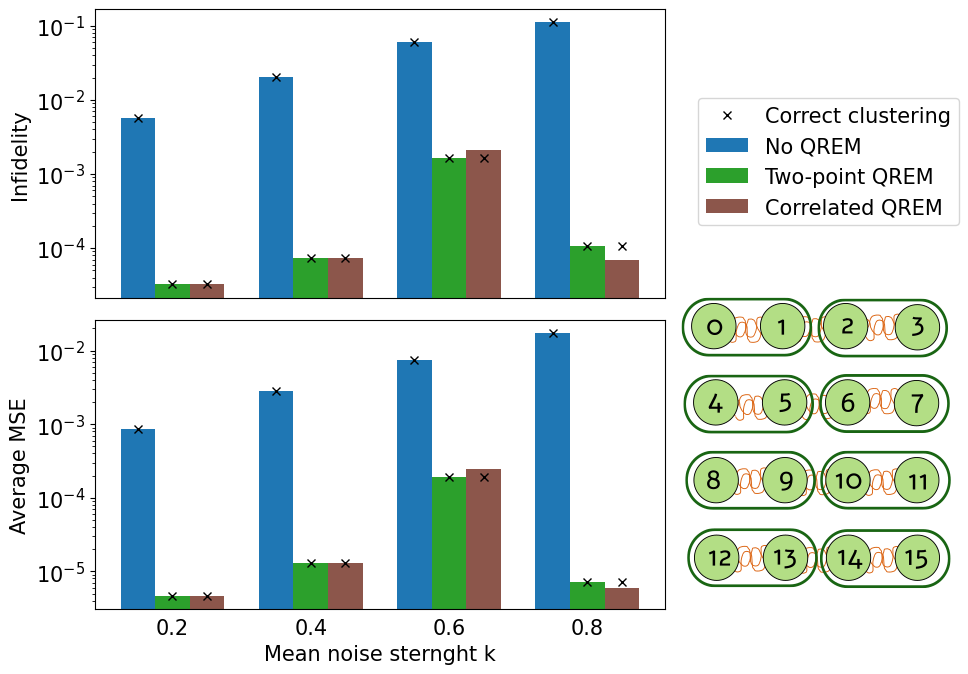

In [ ]:
# Plotting
# Load in all the different k-mean results
traced_down_rho_true_matrix = []
standard_state_matrix = []
corrected_clustering_state_matrix = []
label_matrix = []

for k_it in range(len(k_mean_array)):
    with open(f'{data_path}/k={k_mean_array[k_it]}result_QST.npy', 'rb') as f:
        standard_result_QST_dict =  np.load(f, allow_pickle=True).item()
        correct_clustering_result_QST_dict = np.load(f, allow_pickle=True).item()
    traced_down_rho_true_array = standard_result_QST_dict['traced_down_rho_true_array']

    standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_result_QST_dict)
    correct_clustering_state_array, _ = ot.load_state_array_from_result_dict(correct_clustering_result_QST_dict)
    traced_down_rho_true_matrix.append([traced_down_rho_true_array]) # The brackets is since it is not averaged over states
    standard_state_matrix.append(standard_state_array)
    corrected_clustering_state_matrix.append(correct_clustering_state_array)
    label_matrix.append(label_array)

n_averages = standard_result_QST_dict['n_average']
two_point_corr_labels   = standard_result_QST_dict['two_point_corr_labels']


# # Compute infidelities:
# np.mean(compute_infidelities(rho_array,rho_true_array),axis = 0)

x = np.arange(len(k_mean_array))  # the k-mean label locations
color_array = ['C0', 'C2', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

def average_infidelities(rho_array ,rho_true_array):
    """
    Averages the infidelities over the different correlators.
    """
    inf_array = [[[[sf.qubit_infidelity(rho_array[i][j][k][l], rho_true_array[i][0][k][l]) for l in range(len(rho_array[i][j][k]))] for k in range(len(rho_array[i][j]))] for j in range(len(rho_array[i]))] for i in range(len(rho_array))]    
    print(inf_array)
    return np.mean(inf_array, axis = (2,3))

inf_average_standard= average_infidelities(standard_state_matrix, traced_down_rho_true_matrix)
inf_average_corrected_clustering = average_infidelities(corrected_clustering_state_matrix, traced_down_rho_true_matrix)
for i in range(3): #attribute, cluster_state, perfect_state, unsampled_perfect_state_array in zip(label_array, state_from_cluster_array, perfect_state_array, unsampled_perfect_state_array):
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_average_standard.T[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].plot(x + offset, inf_average_corrected_clustering.T[i], "kx", label="Correct clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, k_mean_array)
ax[0].set_ylabel('Infidelity')


# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)

def compute_mean_MSE(true_exp_value, exp_value_array):
    """
    exp values comes in the shape of (k_mean,n_method,n_averages, n_ops, n_correlators)
    Want to return the mean MSE of the exp values on the form of n_method x n_correlators
    """
    
    return np.array(np.mean((true_exp_value - exp_value_array)**2,axis = (2,3,4)))

def compute_exp_values(state_array,op_array):
    """
    Computes the expectation value of the states with the op_array
    """
    return np.einsum('kanmij,lji->akmnl', state_array, op_array).real

true_exp_value = compute_exp_values(traced_down_rho_true_matrix,op_string_array)
stadard_exp_value = compute_exp_values(standard_state_matrix,op_string_array)
standard_mean_MSE = compute_mean_MSE(true_exp_value, stadard_exp_value)
correct_clustering_exp_value_array = compute_exp_values(corrected_clustering_state_matrix,op_string_array)
correct_clustering_MSE_array = compute_mean_MSE(true_exp_value, correct_clustering_exp_value_array)


multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, standard_mean_MSE[i], width, color = color_array[i])
    ax[1].plot(x + offset, correct_clustering_MSE_array[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')


ax[-1].set_xticks(x + 1*width, k_mean_array)

ax[-1].set_xticks(x + 1*width, k_mean_array)
ax[-1].set_xlabel('Mean noise sternght k')

img = plt.imread("images/cluster_formation_16-two-two.png")
fig.figimage(img, 680, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom = True) # labels along the bottom edge are off


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1,0.75))

## Plotting for the coherent error case

In [ ]:
# Plotting
# Load in all the different k-mean results
traced_down_rho_true_matrix = []
standard_state_matrix = []
corrected_clustering_state_matrix = []
label_matrix = []

for k_it in range(len(k_mean_array)):
    with open(f'{data_path}/k={k_mean_array[k_it]}result_QST.npy', 'rb') as f:
        standard_result_QST_dict =  np.load(f, allow_pickle=True).item()
        correct_clustering_result_QST_dict = np.load(f, allow_pickle=True).item()
    traced_down_rho_true_array = standard_result_QST_dict['traced_down_rho_true_array']

    standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_result_QST_dict)
    correct_clustering_state_array, _ = ot.load_state_array_from_result_dict(correct_clustering_result_QST_dict)
    traced_down_rho_true_matrix.append([traced_down_rho_true_array]) # The brackets is since it is not averaged over states
    standard_state_matrix.append(standard_state_array)
    corrected_clustering_state_matrix.append(correct_clustering_state_array)
    label_matrix.append(label_array)

n_averages = standard_result_QST_dict['n_average']
two_point_corr_labels   = standard_result_QST_dict['two_point_corr_labels']


# # Compute infidelities:
# np.mean(compute_infidelities(rho_array,rho_true_array),axis = 0)

x = np.arange(len(k_mean_array))  # the k-mean label locations
color_array = ['C0', 'C2', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

def average_infidelities(rho_array ,rho_true_array):
    """
    Averages the infidelities over the different correlators.
    """
    inf_array = [[[[sf.qubit_infidelity(rho_array[i][j][k][l], rho_true_array[i][0][k][l]) for l in range(len(rho_array[i][j][k]))] for k in range(len(rho_array[i][j]))] for j in range(len(rho_array[i]))] for i in range(len(rho_array))]    
    print(inf_array)
    return np.mean(inf_array, axis = (2,3))

inf_average_standard= average_infidelities(standard_state_matrix, traced_down_rho_true_matrix)
inf_average_corrected_clustering = average_infidelities(corrected_clustering_state_matrix, traced_down_rho_true_matrix)
for i in range(3): #attribute, cluster_state, perfect_state, unsampled_perfect_state_array in zip(label_array, state_from_cluster_array, perfect_state_array, unsampled_perfect_state_array):
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_average_standard.T[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].plot(x + offset, inf_average_corrected_clustering.T[i], "kx", label="Correct clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, k_mean_array)
ax[0].set_ylabel('Infidelity')


# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)

def compute_mean_MSE(true_exp_value, exp_value_array):
    """
    exp values comes in the shape of (k_mean,n_method,n_averages, n_ops, n_correlators)
    Want to return the mean MSE of the exp values on the form of n_method x n_correlators
    """
    
    return np.array(np.mean((true_exp_value - exp_value_array)**2,axis = (2,3,4)))

def compute_exp_values(state_array,op_array):
    """
    Computes the expectation value of the states with the op_array
    """
    return np.einsum('kanmij,lji->akmnl', state_array, op_array).real

true_exp_value = compute_exp_values(traced_down_rho_true_matrix,op_string_array)
stadard_exp_value = compute_exp_values(standard_state_matrix,op_string_array)
standard_mean_MSE = compute_mean_MSE(true_exp_value, stadard_exp_value)
correct_clustering_exp_value_array = compute_exp_values(corrected_clustering_state_matrix,op_string_array)
correct_clustering_MSE_array = compute_mean_MSE(true_exp_value, correct_clustering_exp_value_array)


multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, standard_mean_MSE[i], width, color = color_array[i])
    ax[1].plot(x + offset, correct_clustering_MSE_array[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')


ax[-1].set_xticks(x + 1*width, k_mean_array)

ax[-1].set_xticks(x + 1*width, k_mean_array)
ax[-1].set_xlabel('Mean noise sternght k')

img = plt.imread("images/cluster_formation_16.png")
fig.figimage(img, 680, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom = True) # labels along the bottom edge are off


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1,0.75))

# 100 qubit example, random correlators

# GHZ states comparison with RShadow

# Runtime/scaling visualization

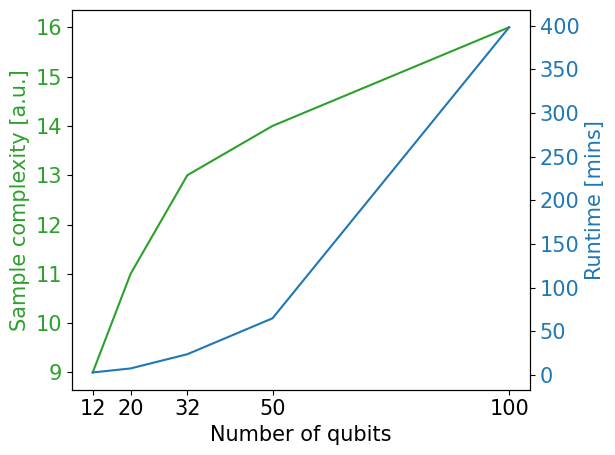

In [ ]:
# Create some mock data
n_qubits = [12, 20,32,50,100]
sample_complexity = np.array([9,11,13,14,16])#np.join(([1,2,3],[])))
comp_runtime = [3,7.6,23.9,65,398]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel(r'Sample complexity [a.u.]',color=color)
ax1.plot(n_qubits, sample_complexity,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set(xticks=n_qubits)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Runtime [mins]', color=color)  # we already handled the x-label with ax1
ax2.plot(n_qubits, comp_runtime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
